**1. Installing the requirements**


In [ ]:
# for mxnet
!pip install --upgrade mxnet
# for pytorch
!pip install torch==1.6.0+cpu torchvision==0.7.0+cpu -f https://download.pytorch.org/whl/torch_stable.html

!pip install --upgrade gluoncv

!pip install mxnet-cu101

!pip install decord

     |████████████████████████████████| 46.9MB 61kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 154.6MB 80kB/s 
     |████████████████████████████████| 5.1MB 55.5MB/s 
ERROR: torchtext 0.10.0 has requirement torch==1.9.0, but you'll have torch 1.6.0+cpu which is incompatible.
  Found existing installation: torch 1.9.0+cu102
    Uninstalling torch-1.9.0+cu102:
      Successfully uninstalled torch-1.9.0+cu102


**2. Changing the working directory**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Don't forget to mount the google drive
%cd drive/MyDrive/Colab\ Notebooks

/content/drive/MyDrive/Colab Notebooks


**3. Importing the requirments**

In [ ]:
from __future__ import division

import argparse, time, logging, os, sys, math

import numpy as np
import mxnet as mx
import gluoncv as gcv
from mxnet import gluon, nd, init, context
from mxnet import autograd as ag
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

from gluoncv.data.transforms import video
from gluoncv.data import VideoClsCustom
from gluoncv.model_zoo import get_model
from gluoncv.utils import makedirs, LRSequential, LRScheduler, split_and_load, TrainingHistory

from gluoncv.utils.filesystem import try_import_decord
decord = try_import_decord()

/usr/local/lib/python3.7/dist-packages/gluoncv/__init__.py:40: UserWarning: Both `mxnet==1.8.0` and `torch==1.6.0+cpu` are installed. You might encounter increased GPU memory footprint if both framework are used at the same time.
  warnings.warn(f'Both `mxnet=={mx.__version__}` and `torch=={torch.__version__}` are installed. '


**4. Setting and loading the data**

In [ ]:
num_gpus = 1
ctx = [mx.gpu(i) for i in range(num_gpus)]
# transform_train = video.VideoGroupTrainTransform(size=(224, 224), scale_ratios=[1.0, 0.8], mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

transform_train = transforms.Compose([
    # Fix the input video frames size as 256×340 and randomly sample the cropping width and height from
    # {256,224,192,168}. After that, resize the cropped regions to 224 × 224.
    video.VideoMultiScaleCrop(size=(224, 224), scale_ratios=[1.0, 0.875, 0.75, 0.66]),
    # Randomly flip the video frames horizontally
    video.VideoRandomHorizontalFlip(),
    # Transpose the video frames from height*width*num_channels to num_channels*height*width
    # and map values from [0, 255] to [0,1]
    video.VideoToTensor(),
    # Normalize the video frames with mean and standard deviation calculated across all images
    video.VideoNormalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

per_device_batch_size = 5
num_workers = 0
batch_size = per_device_batch_size * num_gpus

train_dataset = VideoClsCustom(root=os.path.expanduser('DataSet/train/'),
                               setting=os.path.expanduser('DataSet/train/train.txt'),
                               train=True,
                               new_length=64,
                               new_step=2,
                               video_loader=True,
                               use_decord=True,
                               transform=transform_train)

print('Load %d training samples.' % len(train_dataset))
train_data = gluon.data.DataLoader(train_dataset, batch_size=batch_size,
                                   shuffle=True, num_workers=num_workers)

Load 3136 training samples.


**5. Loading the model**

In [ ]:
net = get_model(name='i3d_resnet50_v1_custom', nclass=64)
net.collect_params().reset_ctx(ctx)
print(net)

  0%|          | 0/55344 [00:00<?, ?KB/s]

100%|██████████| 55344/55344 [00:01<00:00, 52552.60KB/s]


conv0_weight is done with shape:  (64, 3, 5, 7, 7)
batchnorm0_gamma is done with shape:  (64,)
batchnorm0_beta is done with shape:  (64,)
batchnorm0_running_mean is done with shape:  (64,)
batchnorm0_running_var is done with shape:  (64,)
layer1_0_conv0_weight is done with shape:  (64, 64, 3, 1, 1)
layer1_0_batchnorm0_gamma is done with shape:  (64,)
layer1_0_batchnorm0_beta is done with shape:  (64,)
layer1_0_batchnorm0_running_mean is done with shape:  (64,)
layer1_0_batchnorm0_running_var is done with shape:  (64,)
layer1_0_conv1_weight is done with shape:  (64, 64, 1, 3, 3)
layer1_0_batchnorm1_gamma is done with shape:  (64,)
layer1_0_batchnorm1_beta is done with shape:  (64,)
layer1_0_batchnorm1_running_mean is done with shape:  (64,)
layer1_0_batchnorm1_running_var is done with shape:  (64,)
layer1_0_conv2_weight is done with shape:  (256, 64, 1, 1, 1)
layer1_0_batchnorm2_gamma is done with shape:  (256,)
layer1_0_batchnorm2_beta is done with shape:  (256,)
layer1_0_batchnorm2_ru

100%|██████████| 208483/208483 [00:05<00:00, 37492.12KB/s]


I3D_ResNetV1(
  (first_stage): HybridSequential(
    (0): Conv3D(3 -> 64, kernel_size=(5, 7, 7), stride=(2, 2, 2), padding=(2, 3, 3), bias=False)
    (1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=64)
    (2): Activation(relu)
    (3): MaxPool3D(size=(1, 3, 3), stride=(2, 2, 2), padding=(0, 1, 1), ceil_mode=False, global_pool=False, pool_type=max, layout=NCDHW)
  )
  (pool2): MaxPool3D(size=(2, 1, 1), stride=(2, 1, 1), padding=(0, 0, 0), ceil_mode=False, global_pool=False, pool_type=max, layout=NCDHW)
  (res_layers): HybridSequential(
    (0): HybridSequential(
      (0): Bottleneck(
        (bottleneck): HybridSequential(
          (0): Conv3D(64 -> 64, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0), bias=False)
          (1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=64)
          (2): Activation(relu)
          (3): Conv3D(64 -> 64, kernel_size=(1, 3, 3), stride=(1

**6. Setting up the hyperparameters**

In [ ]:
lr_decay = 0.1
# Epochs where learning rate decays
lr_decay_epoch = [40, 80, 100]

# Stochastic gradient descent
optimizer = 'sgd'
# Set parameters
optimizer_params = {'learning_rate': 0.001, 'wd': 0.0001, 'momentum': 0.9}

# Define our trainer for net
trainer = gluon.Trainer(net.collect_params(), optimizer, optimizer_params)

In [ ]:
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

In [ ]:
train_metric = mx.metric.Accuracy()
train_history = TrainingHistory(['training-acc'])
train_history_loss = TrainingHistory(['training-loss'])

**7. Trainning**

[Epoch 0] accuracy= 0.782178 loss= 0.788962 time: 505.046113
[Epoch 1] accuracy= 0.788119 loss= 0.777215 time: 504.466084
[Epoch 2] accuracy= 0.843564 loss= 0.665464 time: 509.990499
[Epoch 3] accuracy= 0.857426 loss= 0.629172 time: 512.872571
[Epoch 4] accuracy= 0.831683 loss= 0.647605 time: 511.418280
[Epoch 5] accuracy= 0.849505 loss= 0.632818 time: 509.013658
[Epoch 6] accuracy= 0.889109 loss= 0.518708 time: 512.958386
[Epoch 7] accuracy= 0.833663 loss= 0.593418 time: 504.404015
[Epoch 8] accuracy= 0.883168 loss= 0.516794 time: 510.111011
[Epoch 9] accuracy= 0.885149 loss= 0.489373 time: 506.823547


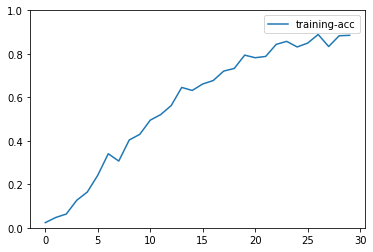

In [ ]:
epochs = 10
lr_decay_count = 0

for epoch in range(epochs):
    tic = time.time()
    train_metric.reset()
    train_loss = 0

    # Learning rate decay
    if epoch == lr_decay_epoch[lr_decay_count]:
        trainer.set_learning_rate(trainer.learning_rate*lr_decay)
        lr_decay_count += 1

    # Loop through each batch of training data
    for i, batch in enumerate(train_data):
        # Extract data and label
        data = split_and_load(batch[0], ctx_list=ctx, batch_axis=0)
        label = split_and_load(batch[1], ctx_list=ctx, batch_axis=0)

        # AutoGrad
        with ag.record():
            output = []
            for _, X in enumerate(data):
                X = X.reshape((-1,) + X.shape[2:])
                pred = net(X)
                output.append(pred)
            loss = [loss_fn(yhat, y) for yhat, y in zip(output, label)]

        # Backpropagation
        for l in loss:
            l.backward()

        # Optimize
        trainer.step(batch_size)

        # Update metrics
        train_loss += sum([l.mean().asscalar() for l in loss])
        train_metric.update(label, output)

        if i == 100:
            break

    name, acc = train_metric.get()

    # Update history and print metrics
    train_history.update([acc])
    train_history_loss.update([train_loss / (i+1)])

    print('[Epoch %d] accuracy= %f loss= %f time: %f' %
        (epoch, acc, train_loss / (i+1), time.time()-tic))

# We can plot the metric scores with:
train_history.plot()

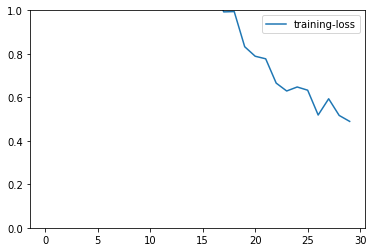

In [ ]:
train_history_loss.plot()

**8. Saving the model**

In [ ]:
net.save_parameters('Model/i3d_resnet50_v1_88.params')

**9. Running my infrence**

In [ ]:
# Map
CLASS_MAP = {
    0: "Opaque",
    1: "Red",
    2: "Green",
    3: "Yellow",
    4: "Bright",
    5: "Light-blue",
    6: "Colors",
    7: "Red",
    8: "Women",
    9: "Enemy",
   10: "Son",
   11: "Man",
   12: "Away",
   13: "Drawer",
   14: "Born",
   15: "Learn",
   16: "Call",
   17: "Skimmer",
   18: "Bitter",
   19: "Sweet milk",
   20: "Milk",
   21: "Water",
   22: "Food",
   23: "Argentina",
   24: "Uruguay",
   25: "Country",
   26: "Last name",
   27: "Where",
   28: "Mock",
   29: "Birthday",
   30: "Breakfast",
   31: "Photo",
   32: "Hungry",
   33: "Map",
   34: "Coin",
   35: "Music",
   36: "Ship",
   37: "None",
   38: "Name",
   39: "Patience",
   40: "Perfume",
   41: "Deaf",
   42: "Trap",
   43: "Rice",
   44: "Barbecue",
   45: "Candy",
   46: "Chewing-gum",
   47: "Spaghetti",
   48: "Yogurt",
   49: "Accept",
   50: "Thanks",
   51: "Shut down",
   52: "Appear",
   53: "To land",
   54: "Catch",
   55: "Help",
   56: "Dance",
   57: "Bathe",
   58: "Buy",
   59: "Copy",
   60: "Run",
   61: "Realize",
   62: "Give",
   63: "Find"
}

In [ ]:
# Reading the test video
video_fname = 'DataSet/test/006_001_001.mp4'
vr = decord.VideoReader(video_fname)
frame_id_list = range(0, 64, 2)
video_data = vr.get_batch(frame_id_list).asnumpy()
clip_input = [video_data[vid, :, :, :] for vid, _ in enumerate(frame_id_list)]

# transform_fn = video.VideoGroupValTransform(size=(224, 224), mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

transform_fn = transforms.Compose([
    # Fix the input video frames size as 256×340 and randomly sample the cropping width and height from
    # {256,224,192,168}. After that, resize the cropped regions to 224 × 224.
    video.VideoMultiScaleCrop(size=(224, 224), scale_ratios=[1.0, 0.875, 0.75, 0.66]),
    # Randomly flip the video frames horizontally
    video.VideoRandomHorizontalFlip(),
    # Transpose the video frames from height*width*num_channels to num_channels*height*width
    # and map values from [0, 255] to [0,1]
    video.VideoToTensor(),
    # Normalize the video frames with mean and standard deviation calculated across all images
    video.VideoNormalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

clip_input = transform_fn(clip_input)
clip_input = np.stack(clip_input, axis=0)
clip_input = clip_input.reshape((-1,) + (32, 3, 224, 224))
clip_input = np.transpose(clip_input, (0, 2, 1, 3, 4))
print('Video data is readed and preprocessed.')

Video data is readed and preprocessed.


In [ ]:
# Running the prediction
pred = net(nd.array(clip_input,  ctx = mx.gpu(0)))
topK = 5
ind = nd.topk(pred, k=topK)[0].astype('int')
print('The input video clip is classified to be')
for i in range(topK):
    print('\t[%s], with probability %.3f.'%
          (CLASS_MAP[ind[i].asscalar()], nd.softmax(pred)[0][ind[i]].asscalar()))

The input video clip is classified to be
	[Light-blue], with probability 0.977.
	[Son], with probability 0.016.
	[Perfume], with probability 0.007.
	[Yellow], with probability 0.000.
	[None], with probability 0.000.
